# Evaluation of the statistical effect of "Divisive Normalization"
---

As we already mentioned in the report, "divisive normalization" (DN) distorts the statistics of the input spikes. This distortion has two forms:
- **time correlation distortion**: for each individual input channel,
- **cross-channel correlation distortion**: across different input channels.

*As an example of former*: consider an input channel in which spikes always appear in clusters. What happens is that in this case, because of using an LFSR with pseudo-random code for producing the output spikes, the cluster correlation disappears completely.

*As an example of the latter*: consider two input channels that have the property thet they cannot fire simolteneously. Intutively speaking, these two channel have a negative correlation. However, since we use the same LFSR to produce the output spikes in both channels, the output spikes are **most of the time** positively correlated. This is simply beacuse if the LFSR number is very large, none of the channels can fire and viseversa if the LFSR number is very low, both channels will fire, thus, a positive correlation. 

In this file, we are going to investigate these effects more precisely using numerical simulations.



## Required packages
Note that we may receive a warning due to JAX package. We may ignore this warning.


In [ ]:
# required packages
# avoid printing output due to JAX warnings

import numpy as np
import matplotlib.pyplot as plt


from scipy.special import ndtri

from scipy import signal

# we turn off the warnings from JAX
import sys
import warnings


# divisive normalization module and axiliary functions
from xylo_divisive_normalisation import DivisiveNormalisation, build_lfsr

from simulation_divisive_normlisation import joint_rv_generator
;




## Setting the parameters for the simulation
Here we set the parameters of the DN module.

In [93]:
## set the parameters for the simulation

shape = (2, 1)  # shape of the Module

chan_num = 2  # number of input channels (for correlation only 2 is enough)

bits_counter = 10  # number of bits in counter
E_frame_counter = np.zeros(chan_num)  # initialize internal counters to 0

IAF_counter = np.zeros(chan_num)  # initialize the internal state of IAF counters

bits_lowpass = 16  # number of bits for implementation of low-pass filter
bits_shift_lowpass = 5  # number of bit shifts for low-pass filter
init_lowpass = 0  # initial value of low-pass filter

fs = 10e3  # global clock frequency in Hz

frame_dt = 50e-3  # frame duration in sec

bits_lfsr = 10  # number of LFSR bits

lfsr_filename = './lfsr_data.txt'  # file name for loading the LFSR code
code_lfsr = build_lfsr(lfsr_filename)  # build the LFSR code

p_local = 12  # ratio  between the local and global clock (should be an even number)


# Test 1: spikes indepndent across channels and time
---
As our first example, we consider two independent Poisson spike processes. 

## Checking the cross-channel correlation
The cross channel correlation of this process is 0 due to the independence. Then, we apply DN and see how much correlation is created between the two channels.


In [94]:
## Test 1:
# see how across_channel independent input spikes get statistically correlated
# as a result of using common LFSRs in the implementation
# no correlation in time


print('\n', '='*15, "Test 1", '='*15)

sim_time = 10  # simulation time in sec
num_in_sample = np.ceil(fs * sim_time).astype('int')  # number of samples in input spikes signals

# probability of firing of the Poisson point process
poisson_prob_in = 0.1

input_rate = np.ceil(fs * poisson_prob_in).astype('int')

# joint histogram and spike generation
marginal_hist = np.array([1 - poisson_prob_in, poisson_prob_in]).reshape(2, 1)
joint_hist = np.outer(marginal_hist, marginal_hist)

input_spike = joint_rv_generator(joint_hist, num_in_sample)

# build the 2-channel simulator
simulator_test1 = DivisiveNormalisation(shape=(chan_num, 1), chan_num=chan_num, bits_counter=bits_counter,
                                        bits_lowpass=bits_lowpass,
                                        bits_shift_lowpass=bits_shift_lowpass, fs=fs, frame_dt=frame_dt,
                                        bits_lfsr=bits_lfsr, code_lfsr=code_lfsr, p_local=p_local)

# simulate the system
output_spike, state = simulator_test1.evolve(input_spike=input_spike, record=True)

# compute the metrics
corr_factor_mat_in, cov_mat_in, mean_vec_in = simulator_test1.corr_metric(input_spike)
corr_factor_mat_out, cov_mat_out, mean_vec_out = simulator_test1.corr_metric(output_spike)

print(f'empirical rate at the input: {mean_vec_in*fs} firings/sec')
print(f'empirical correlation factor at the input: {corr_factor_mat_in[0,1]}\n\n')

print(f'empirical rate at the output: {mean_vec_out*fs*p_local} firings/sec')
print(f'empirical correlation factor at the output: {corr_factor_mat_out[0,1]}')




 =============== Test 1 ===============
empirical rate at the input: [ 998.1 1010.9] firings/sec
empirical correlation factor at the input: 0.0005556467940032656


empirical rate at the output: [117.2 116.6] firings/sec
empirical correlation factor at the output: 0.2242236227654392


## Checking effect of DN on the output rate

To check that DN is indeed doing some good job in normalizing the firing rate of input spikes, we change the input rate and see how the output rate is affected.



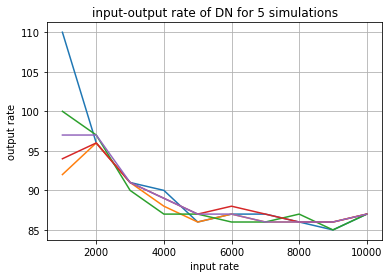

In [95]:
# probability of firing of the Poisson point process
poisson_prob_in_vec = np.linspace(0.1,1,10)

# vector of input & output rates
input_rate = np.ceil(fs * poisson_prob_in_vec).astype('int')

# number of simulations
num_sim=5

output_rate=np.zeros((num_sim,input_rate.size))



for sim in range(num_sim):
    for i, poisson_prob_in in enumerate(poisson_prob_in_vec):

        # joint histogram and spike generation
        marginal_hist = np.array([1 - poisson_prob_in, poisson_prob_in]).reshape(2, 1)
        joint_hist = np.outer(marginal_hist, marginal_hist)

        input_spike = joint_rv_generator(joint_hist, num_in_sample)

        # use the previous simulator

        # simulate the system
        output_spike, state = simulator_test1.evolve(input_spike=input_spike, record=True)

        # compute the metrics
        corr_factor_mat_in, cov_mat_in, mean_vec_in = simulator_test1.corr_metric(output_spike)

        # the output rate
        output_rate[sim,i]=np.ceil(mean_vec_in[1]*fs*p_local).astype(int)
        
# plot the output rate as a function of input rate
plt.figure(1)
for sim in range(num_sim):
    plt.plot(input_rate, output_rate[sim,:])
plt.xlabel('input rate')
plt.ylabel('output rate')
plt.title(f'input-output rate of DN for {num_sim} simulations')
plt.grid(True);
plt.show()
    

    

    

**simple analysis**

It is seen that the output rate is almost independent of the input rate. However, at lower rates there is some fluctation in output rate. This is due to the fact that at lower input rates, the counter values over frame $\{E(t): t=0,1, \dots\}$ are avreaged over a very sparse set of binary-valued input firings, thus, have a higher variance. 

As we illustrated in the report, the ratio between the output and input firing pattern at frame $t$ is proportional to $\frac{E(t)}{M(t)+ \epsilon}$, which varies randomly across frames due to the random arrival of input spikes. We can plot the histogram of this ratio to gain an idea of how concentrated it is (thus, how regular the output firing would be).




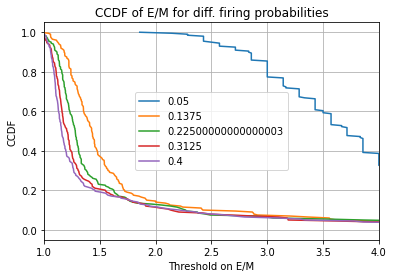

In [98]:
# probability of firing of the Poisson point process
poisson_prob_in_vec = np.linspace(0.05,0.4,5)

# vector of input & output rates
input_rate = np.ceil(fs * poisson_prob_in_vec).astype('int')
output_rate=np.zeros((num_sim,input_rate.size))

for i, poisson_prob_in in enumerate(poisson_prob_in_vec):

    # joint histogram and spike generation
    marginal_hist = np.array([1 - poisson_prob_in, poisson_prob_in]).reshape(2, 1)
    joint_hist = np.outer(marginal_hist, marginal_hist)

    input_spike = joint_rv_generator(joint_hist, num_in_sample)

    # use the previous simulator

    # simulate the system
    output_spike, state = simulator_test1.evolve(input_spike=input_spike, record=True)

    # compute the ratio E(t)/M(t)
    E_M=state['E'][:,0]/state['M'][:,0]
    E_M=np.sort(E_M)
    CCDF=np.linspace(1,0, E_M.size)
    
    # plot
    plt.plot(E_M, CCDF)
    plt.xlim([1,4])
    plt.ylabel('CCDF')
    plt.xlabel('Threshold on E/M')
    plt.title(f'CCDF of E/M for diff. firing probabilities')
    plt.grid(True)
plt.legend(poisson_prob_in_vec)
plt.show()


It is seen that as the firing probability (thus, the input rate) increases, the CCDF in concentrated more and more around $1$, as we showed in our report.

# Test 2: Spikes correlated across channels but independent in time

In the previous test simulation, we showed that DN makes independent spikes in different channels correlated.
In this section, we want to investigate how DN affects the correlation between already correlated channels.

For this simulation, we consider two input channels. Let us denote the binary input of these two channels at a specific time by $(I_1, I_2)$. We assume that the firings are still independent in time. So, to create cross-channel correlation we need to impose a joint probability of firing on $(I_1, I_2)$ that makes them correlated.

We consider the following parametric model for the joint probability, where $\rho \in [0, 0.5]$ is a parametr:

|prob. | 0 | 1
|:---|:-----------------------|:--
| 0| $1- 2 \rho$ | $\rho$
| 1 | $\rho$ | 0

we can see that:
- the marginal probability of firing for both $I_1$ and $I_2$ is given by $P(I_1=1)=P(I_2=1)=\rho$.
- $I_1$ and $I_2$ cannot fire at the same time because $P(I_1,I_2=(1,1))=0$.

The last property indeed allows us to impose a negative correlation between the firing patterns of two channels. We perform  simulations for this case to investigate the effect of DN.

In [99]:
## Test 2:
# produce correlated firing patterns across channles
# no correlation in time

print('\n', '='*15, "Test 2", '='*15, '\n')

sim_time = 10  # simulation time in sec
num_in_sample = np.ceil(fs * sim_time).astype('int')  # number of samples in input spikes signals

# probability of firing of the Poisson point process
poisson_prob_in = 0.1

input_rate = np.ceil(fs * poisson_prob_in).astype('int')

# a toy example for creating correlation:
# if one channel fires, the other does not
# note that in this case "poisson_prob_in" should be in [0,0.5]
joint_hist = np.zeros((2, 2))

joint_hist[0, 0] = 1 - 2 * poisson_prob_in
joint_hist[0, 1] = poisson_prob_in
joint_hist[1, 0] = poisson_prob_in
joint_hist[1, 1] = 0  # this avoid simultaneous firings

# produce correlated spikes
input_spike = joint_rv_generator(joint_hist, num_in_sample)

# build the 2-channel simulator
simulator_test2 = DivisiveNormalisation(shape=(chan_num, 1), chan_num=chan_num, bits_counter=bits_counter,
                                        bits_lowpass=bits_lowpass,
                                        bits_shift_lowpass=bits_shift_lowpass, fs=fs, frame_dt=frame_dt,
                                        bits_lfsr=bits_lfsr, code_lfsr=code_lfsr, p_local=p_local)

# simulate the system
output_spike, state = simulator_test2.evolve(input_spike=input_spike, record=True)

# compute the metrics
corr_factor_mat_in, cov_mat_in, mean_vec_in = simulator_test2.corr_metric(input_spike)
corr_factor_mat_out, cov_mat_out, mean_vec_out = simulator_test2.corr_metric(output_spike)

print(f'empirical rate at the input: {mean_vec_in*fs}')
print(f'empirical correlation factor at the input: {corr_factor_mat_in[0,1]}\n\n')

print(f'empirical rate at the output: {mean_vec_out*fs*p_local}')
print(f'empirical correlation factor at the output: {corr_factor_mat_out[0,1]}')




 =============== Test 2 =============== 

empirical rate at the input: [1000.1  990.6]
empirical correlation factor at the input: -0.11053609018284644


empirical rate at the output: [120.  121.7]
empirical correlation factor at the output: 0.24831827368639878


**remark**

It is seen that the cross-channel correlation at the output is positive, which is not compatible with the negative cross-channel correlation at the input. As we already discussed, this positive correlation is artificially created due to use of the same LFSR for all channels and may create significant statistical distortion and signal processing issues in the next SNN layers.

# Test 3: spikes correlated in time but independent across channels

As a last test, we consider a scenario where the input channels are independent but the firing patterns in each channel are correlated in time. This is typically the case in biological scenarios where a firing neuron cannot fire immediately after it has fired or in audio applications where firings happens in clusters as a specific frequency corresponding to a specific channel is triggered due to the presence of some keyword. 
In both cases, correlations in time contain significant information for signal processing applications such as detection and classification.

In this test, we would like to investigate how the presence of LFSR distorts the time correlation. Note that for a given spike count $E(t)$ over a specific frame $t$, the LFSR output is compared (with clock frequency) with $E(t)$ and a spike is generated if it surpasses $E(t)$. Since the adjacent samples of LFSR are almost independent (pseudo-random), the spikes produced by LFSR will be almost uncorrelated in time, thus, distortion in the time correlation.

## how to produce time-correlated spikes? 
Let $I_i, i=0,1,\dots$ denote the consecutive input values in a channel (with a clock frequency) where $I_i=1$ if there is a firing. To induce time-correlation we need to produce correlated binary signal. This is unfortunately, very difficult because for $N$ binary random variables, we have a joint density over $2^N$ binary sequences. And as $N$ gets larger, it would be numerically impossible to create such a correlated sequence in a reasonable time.

To avoid this problem, we use correlated Gaussian variables and apply truncation to produce binary vectors. One of the advantages of this method is that producing correlated Gaussain vectors of size $N$ simply requires producing $N$ i.i.d. Gaussian vectors and multiplying them with the square-root of the covariance matrix we desire to have, thus, the time complexity is at most of the order $O(N^2)$ or $O(N^3)$ if the square-root of the covariance is unknown.

Here, we use the follwoing simple method. We produce independent zero-mean unit-variance Gaussian RVs $Z_0, Z_1, \dots$ and pass them through a first-order filter of the form 
$$X_{n}= \rho X_{n-1} + \sqrt{1-\rho^2} Z_n$$
where $\rho$ has an amplitude in the range $(0,1)$. The correlation of $X_0, X_1, \dots$ can be checked to be of the form
$$\mathbf{E}(X_n X_{n-m})= \rho^{|m|}.$$
Therefore, by choosing $|\rho|$ closer to $1$ we can create more correlated output RVs $X_0,X_1, \dots$ whereas for $\rho=1$ we obtain the i.i.d. input sequence $X_i=Z_i$.

We can also check that all the output RVs $X_0, X_1, \dots$ are zero-mean unit-variance Gassian variables.

To convert the correlated Gaussian vector $X_0, X_1, \dots$ to the desired binary vector we apply the following thresholding 
$$I_n=u(X_n-\eta)$$
where $\eta$ is a threshold parameter and $u(.)$ is the step function. 

Using simple probabilistic analysis, we can show that:
- $P(I_n=1)=P(X_n > a)= Q(a)$ where $Q(.)$ is the well-known Q-function corresponding to tail of the Gaussian PDF.

- The correlation $\mathbf{E}(I_{n} I_{n-m})=: c_I(m)$ is given by $g(c_X(m))$ in terms of the correlation $\mathbf{E}(X_{n} X_{n-m})=: c_X(m)=\rho^{|m|}$ where the function $g$ is given by 
$$g(s)= \int_{0}^s \frac{1}{2\pi} \exp(-\frac{a^2}{1+t}) dt$$
where $a$ is the value of the threshold we have selected.
Note that $g(s)$ is an increasing function of $s$. As a result, more correlated Gaussian RVs ($X_n, X_{n-m}$) produce more correlated binary RVs ($I_n ,I_{n-m}$).


For a given input rate:
- we choose $a$ to fulfill the average input rate.
- plugin the value of $a$ to compute the function $g(.)$. Then, we adjust the correlation parameter $\rho$ such that we obtain the desired correlation for the output binary sequence $I_0, I_1, \dots$.

The following simulation applies this technique. To illustrate the effect of time correlation, we define a parameter **corr_length** which specifies until which depth (delay in time) we are interested to compute the time-correlation.

**Important remark**

One should note that the input spikes have a sampling rate given by the global clock frequency $fs$ whereas the output spikes have a higher clock rate $p_{local} f_s$ where $p_{local}$ is the ratio between the local and global clock frequency. Because of this difference in time scales, we need to compute the correlation of the output spikes over $p_{local} \times$**corr-length**, and then downsample it by a factor $p_{local}$ to obtain comparable correlations between the input and the output.



 =============== Test 3 =============== 



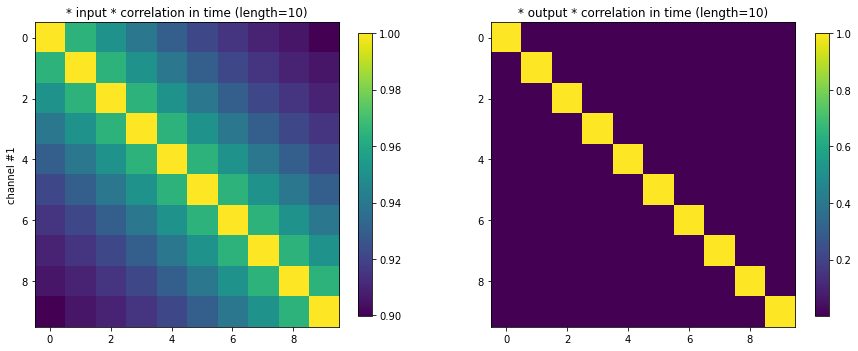

In [100]:
## Test 3
# take the effect of time correlation into account
print('\n', '='*15, "Test 3", '='*15, '\n')

sim_time = 10  # simulation time in sec
num_in_sample = np.ceil(fs * sim_time).astype('int')  # number of samples in input spikes signals

# Method:
# (i) produce correlated Gaussian variables (X1,X2)
# (ii) produce spike as (u(X1-trunc_thre), u(x2-trunc_thre)) with step function u(.)
# and a truncation threshold "trunc_thre"

# compute the truncation_threshold
corr_factor = 0.999  # correlation factor
poisson_prob_in = 0.1  # firing rates

trunc_thre = ndtri(1 - poisson_prob_in)

# i.i.d. Gaussain RV
G = np.random.randn(2 * num_in_sample).reshape(num_in_sample, 2)


# parameters of the 1-st order filter
a_filt = np.array([1, -corr_factor])
b_filt = np.array([np.sqrt(1 - corr_factor ** 2)])

# rescale the first row of G to converge to the stationary solution at the first step
G[0,:]/=b_filt

G_corr = signal.lfilter(b_filt, a_filt, G, axis=0)

# quantize using the threshold to obtain the correlated spikes (correlation just in time)
input_spike=(G_corr>trunc_thre)

# build the 2-channel simulator
# change p_local for short-correlation checking
p_local=2
simulator_test3 = DivisiveNormalisation(shape=(chan_num, 1), chan_num=chan_num, bits_counter=bits_counter,
                                        bits_lowpass=bits_lowpass,
                                        bits_shift_lowpass=bits_shift_lowpass, fs=fs, frame_dt=frame_dt,
                                        bits_lfsr=bits_lfsr, code_lfsr=code_lfsr, p_local=p_local)

# simulate the system
output_spike, state = simulator_test3.evolve(input_spike=input_spike, record=True)

# also investigate the correlation across time
# compute the correlation up to a specific delay "corr_length"
# method: convert each channel into "corr_length" channels each having
# a different delay

corr_length=10
channel=1

# at the input
delay_sample_in=np.zeros((input_spike.shape[0]-corr_length+1, corr_length))
for i in range(corr_length):
    delay_sample_in[:,i]=input_spike[i:i+delay_sample_in.shape[0], channel]


# at the output
# note that the time-scale of output is smaller by a factor p_local
corr_length_out=p_local*corr_length
delay_sample_out=np.zeros((output_spike.shape[0]-corr_length_out+1, corr_length_out))

for i in range(corr_length_out):
    delay_sample_out[:,i]=output_spike[i:i+delay_sample_out.shape[0], channel]

# compute covariance matrix and correlation factors
corr_factor_mat_in, cov_mat_in, mean_vec_in = simulator_test3.corr_metric(delay_sample_in)
corr_factor_mat_out, cov_mat_out, mean_vec_out = simulator_test3.corr_metric(delay_sample_out)

# average out corr_factor_mat_out by a factor p_local
corr_factor_mat_out_adjusted=corr_factor_mat_out[::p_local, ::p_local]


"""
print(f'* input * empirical correlation-factor matrix for channel {channel}: {corr_factor_mat_in}')
print(f'* output * empirical correlation-factor matrix for channel {channel}: {corr_factor_mat_out}')
"""
    
    
plt.figure(3, figsize=[15,40])
plt.subplot(121)
fig=plt.imshow(np.abs(corr_factor_mat_in))
plt.colorbar(fig, shrink=0.13)
plt.title(f'* input * correlation in time (length={corr_length})')
plt.ylabel('channel #1')
plt.subplot(122)
fig=plt.imshow(np.abs(corr_factor_mat_out_adjusted))
plt.title(f'* output * correlation in time (length={corr_length})')
plt.colorbar(fig, shrink=0.13)


The simulation results show that eventhough the input spikes are highly correlated, the resulting output spikes have almost zero-correlation even over very short intervals we have simulated here. As we explained before, this is due to the fact that the LFSR adopted in DN, always generates almost i.i.d. spikes, thus, it destroys the time-correlation of the input spikes.

# Symmary and conclusion
In this report, we investigated the performance of the proposed devisive normalization scheme using numerical simulations. We showed that
- the proposed method is able to normalize very well the output spike rate over a large range of input rates, although for very small rates it causes much larger statistical fluctuations for the output rate.

- the shared LFSR adopted in the design may create significant statistical distortion in the input spike channels. We illustrated this by studying two types of correlation: cross-channel correlation (between different channels) and time correlation (for each channel across time).